In [1]:
import numpy as np
import pandas as pd
from pymongo import MongoClient
import pymongo
from pprint import pprint 

In [2]:
# plot settings
import matplotlib.pyplot as plt

FIGSIZE_TWOCOL = (10,4)
FIGSIZE_ONECOL = (5,4)

SMALL_SIZE = 13
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size= MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize= MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize= MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [3]:
df=pd.read_csv('hubs.csv')
df = df.drop(df.columns[0], axis=1)
df.head()

   degree        id         C        cc  in_degree  out_degree
0   19065    807095  0.002633  0.417001      19064           9
1   14637   1652541  0.003601  0.510699      14629          47
2   13144   2467791  0.004233  0.440488      13129          56
3   12217  87818409  0.004283  0.434341      12200          54
4   10752    816653  0.002871  0.459824      10744          29

In [4]:
CLIENT = MongoClient()
DB = CLIENT['social_database_test']
db = CLIENT.social_database_test

In [5]:
tweets = db.merged_03_17_25

In [6]:
names=[]
screen_names = []
followers = []
friends = []
for i in range(df.shape[0]):
    for userid in tweets.find( {"id":int (df['id'][i])}):
        names.append( userid['name'] )
        screen_names.append( '@'+userid['screen_name'] )
        followers.append(userid['followers_count'])
        friends.append(userid['friends_count'])

print names[:10]
print screen_names[:10]

[u'The New York Times', u'Reuters Top News', u'Washington Post', u'The Guardian', u'TechCrunch', u'TIME', u'HuffPost', u'Forbes', u'The Onion', u'BBC News (UK)']
[u'@nytimes', u'@Reuters', u'@washingtonpost', u'@guardian', u'@TechCrunch', u'@TIME', u'@HuffPost', u'@Forbes', u'@TheOnion', u'@BBCNews']


In [7]:
tweets.find_one()

{u'_id': ObjectId('5b17c2a5e4721c6552885fd1'),
 u'created_at': u'Mon Mar 12 23:09:05 +0000 2007',
 u'day': 19,
 u'favorite_count': 24,
 u'favourites_count': 7502,
 u'followers_count': 31333,
 u'friends_count': 9491,
 u'hashtags': [u'deletefacebook'],
 u'hour': 22,
 u'id': 1051731,
 u'lang': u'en',
 u'name': u'David Berkowitz',
 u'retweets': 0,
 u'screen_name': u'dberkowitz',
 u'statuses_count': 18904,
 u'tweet_created_at': u'Mon Mar 19 22:34:59 +0000 2018',
 u'tweets': 4}

In [8]:
df['name'] = names
df['screen_name'] = screen_names
df['followers'] = followers
df['friends'] = friends

In [9]:
df = df.sort_values('in_degree', ascending=False)

In [10]:
df['Interest'] = df['in_degree']/df['followers']
df['LogInterest'] = np.log10(df['in_degree'])/np.log10(df['followers'])

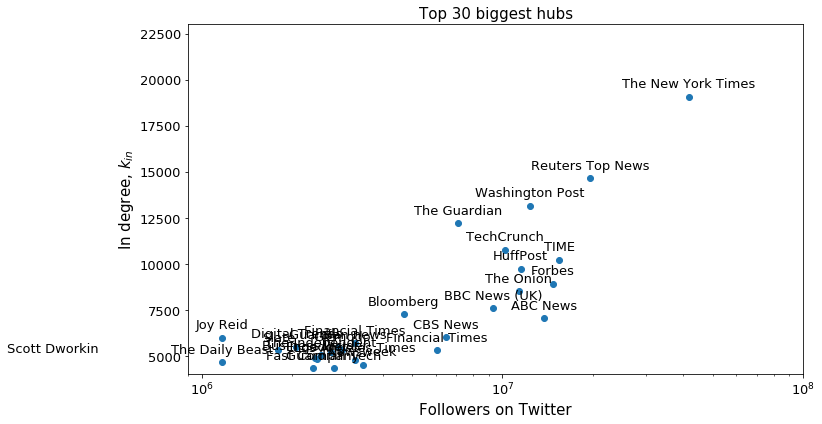

In [11]:
fig,ax = plt.subplots(figsize = (10,6))
n = 30
plt.plot(df['followers'][:n], df['degree'][:n], 'o')
for i in range(n):
    plt.text(df['followers'][i],df['degree'][i]+500, str(df['name'][i]),ha ='center', fontsize =13)

plt.xlabel('Followers on Twitter')
plt.ylabel('In degree, $k_{in}$')
plt.title('Top {} biggest hubs'.format(n))
plt.xlim(10**6-100000, 10**8)    
plt.ylim(4*10**3, 2*10**4+3000)
ax.set_xscale('log')
#plt.loglog()
plt.tight_layout()
plt.savefig('./imgs/hubs_followers.pdf', format='pdf')

In [12]:
df_interest = df.sort_values('in_degree',ascending=False).iloc[:n]
df_interest = df_interest.sort_values('Interest')

In [13]:
lab_screen =df_interest['screen_name'][:n]
lab =df_interest['name'][:n]
lab = lab+" "+lab_screen
nums = range(n,0,-1)
lab = [ l+", "+str(nums[i])   for i,l in enumerate(lab) ]

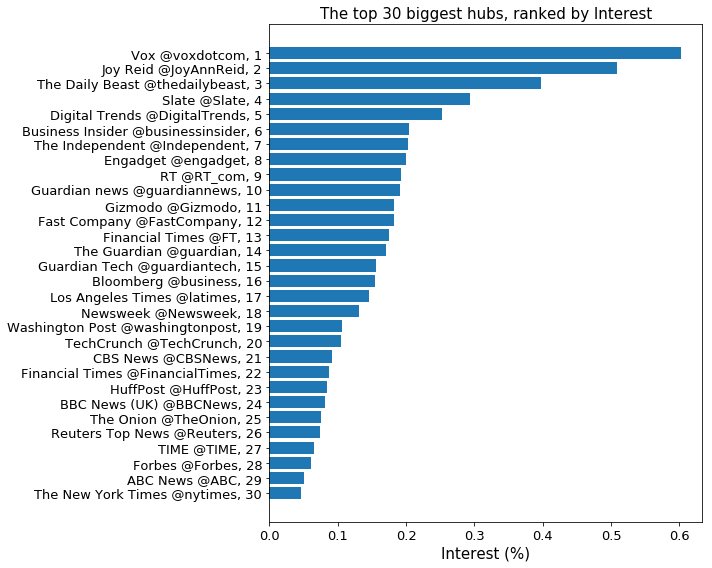

In [14]:
plt.subplots(figsize=(10,8))
X=df_interest['Interest'][:n]*100
#X=df_interest['Interest'][:n]
plt.barh(range(n), X)
#plt.barh(range(n),df_interest['followers'])
##plt.barh(range(n),df_interest['C'])
plt.yticks( range(n),lab)
plt.title('The top {} biggest hubs, ranked by Interest'.format(n))
plt.xlabel('Interest (%)')
plt.tight_layout()
plt.savefig('./imgs/hubs_interest.pdf', format='pdf')

In [15]:
df_interest.tail()

    degree          id         C        cc  in_degree  out_degree  \
15    5491    14763734  0.004315  0.398339       5215        4102   
19    5304    15164565  0.010028  0.428451       5294          29   
26    4667    16012783  0.013409  0.387894       4646          47   
13    5991    49698134  0.014402  0.422554       5921         174   
30    4261  2347049341  0.008585  0.436986       4259           9   

               name     screen_name  followers  friends  Interest  LogInterest  
15   Digital Trends  @DigitalTrends    2063955  1239048  0.002527     0.588667  
19            Slate          @Slate    1798290      622  0.002944     0.595343  
26  The Daily Beast  @thedailybeast    1166723      939  0.003982     0.604434  
13         Joy Reid     @JoyAnnReid    1163897     4930  0.005087     0.621900  
30              Vox      @voxdotcom     706276      250  0.006030     0.620503  

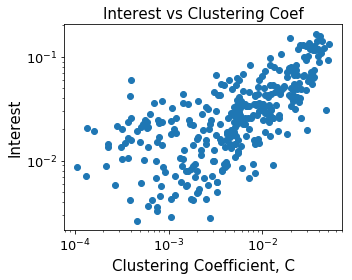

In [16]:
fig,ax = plt.subplots(figsize = FIGSIZE_ONECOL)
plt.plot(df['Interest'],df['C'], 'o')
plt.loglog()
ax.set_xscale('log')
plt.ylabel('Interest')
plt.xlabel('Clustering Coefficient, C')
plt.title('Interest vs Clustering Coef')
plt.tight_layout()

plt.savefig('./imgs/hubs_interest_corr.pdf', format='pdf')


In [17]:
df_temp = df
df_temp = df_temp.drop('id', axis = 1)
df_temp =df_temp.drop('LogInterest', axis = 1)
df_cor =df_temp.corr()
df_cor

              degree         C        cc  in_degree  out_degree  followers  \
degree      1.000000 -0.366416  0.083563   0.992172   -0.065970   0.745011   
C          -0.366416  1.000000  0.047060  -0.374973    0.323646  -0.325780   
cc          0.083563  0.047060  1.000000   0.087277    0.017048   0.085527   
in_degree   0.992172 -0.374973  0.087277   1.000000   -0.147590   0.755753   
out_degree -0.065970  0.323646  0.017048  -0.147590    1.000000  -0.249879   
followers   0.745011 -0.325780  0.085527   0.755753   -0.249879   1.000000   
friends     0.039982 -0.012340 -0.005785  -0.006268    0.685159  -0.102150   
Interest   -0.263736  0.788472  0.053650  -0.269682    0.364691  -0.324531   

             friends  Interest  
degree      0.039982 -0.263736  
C          -0.012340  0.788472  
cc         -0.005785  0.053650  
in_degree  -0.006268 -0.269682  
out_degree  0.685159  0.364691  
followers  -0.102150 -0.324531  
friends     1.000000 -0.050136  
Interest   -0.050136  1.000000  

In [18]:
df_cor.head()
Y_cor = df_cor['Interest'].sort_values()
Y_cor = Y_cor[:-1]
Y_cor.index

Index([u'followers', u'in_degree', u'degree', u'friends', u'cc', u'out_degree',
       u'C'],
      dtype='object')

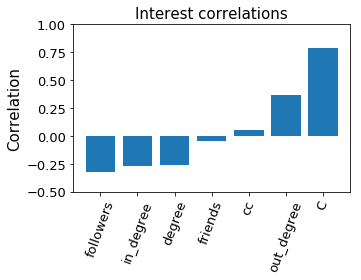

In [19]:
X_cor = range(len(Y_cor))
plt.subplots(figsize = FIGSIZE_ONECOL)
plt.bar(X_cor, Y_cor)
plt.xticks(X_cor, Y_cor.index, rotation = 70)
plt.ylim(-0.5,1)
plt.title("Interest correlations")
plt.ylabel("Correlation")
plt.tight_layout()
plt.savefig('./imgs/hubs_interest_corr_hist.pdf', format='pdf')

# Estrazione italiani

In [23]:
import collections
import networkx as nx
import numpy as np
import os
import random
from sklearn import linear_model
import json as json


In [8]:
g = nx.read_edgelist('../network/networks/edge_list.txt',
                     create_using=nx.DiGraph(), nodetype=int, data=False)

In [9]:
temp = g.nodes()
nodes = [nd for nd in temp]


In [10]:
names=[]
screen_names = []
followers = []
friends = []
users = []

for userid in tweets.find( {"lang": "it"}).sort('followers_count', pymongo.DESCENDING):
    users.append(userid)
    names.append( userid['name'] )
    screen_names.append( '@'+userid['screen_name'] )
    followers.append(userid['followers_count'])
    friends.append(userid['friends_count'])


In [11]:
user_ids_db = [u['id'] for u in users]

In [12]:
italian_users = set(nodes) & set(user_ids_db)

In [13]:
len(italian_users)

2392

In [17]:
len(names)

2464

In [23]:
g_ita = nx.subgraph(g, italian_users)

In [ ]:
##nx.write_edgelist(g_ita, '../network/networks/g_ita_edge_list.txt')

# Italian hubs

In [20]:
import datetime 
import time


In [24]:
g_ita = nx.read_edgelist('../network/networks/g_ita_edge_list.txt',
                     create_using=nx.DiGraph(), nodetype=int, data=False)


In [25]:
g_ita_und = g_ita.to_undirected()

In [27]:
nodes = { n:d for n,d in g_ita_und.degree()}
nodes_ids = nodes.keys()
df_ita= pd.DataFrame({'id':nodes_ids, 'degree': [ nodes[h] for h in nodes_ids] })

In [28]:
start = datetime.datetime.now()
clusters = nx.clustering(g_ita_und, nodes_ids)
end = datetime.datetime.now()

In [29]:
df_ita['C'] = [clusters[h] for h in nodes_ids]
df_ita.head()

   degree                  id         C
0     101  715597025404968960  0.119208
1      44  830401574958727168  0.163848
2      12  710844636160507906  0.363636
3       5  859911951140388867  0.200000
4      18  756546140644974596  0.444444

In [31]:
temp = g_ita.in_degree()
in_degree = {n:d for n,d in temp}
df_ita['in_degree'] = [in_degree[h] for h in df_ita['id']]

temp = g_ita.out_degree()
out_degree = {n:d for n,d in temp}
df_ita['out_degree'] = [out_degree[h] for h in df_ita['id']]

In [32]:
df_ita.head()

   degree                  id         C  in_degree  out_degree
0     101  715597025404968960  0.119208        100           5
1      44  830401574958727168  0.163848         42          23
2      12  710844636160507906  0.363636          8           9
3       5  859911951140388867  0.200000          2           5
4      18  756546140644974596  0.444444         18           0

In [33]:
names=[]
screen_names = []
followers = []
friends = []
for i in range(df_ita.shape[0]):
    for userid in tweets.find( {"id":int (df_ita['id'][i])}):
        names.append( userid['name'] )
        screen_names.append( '@'+userid['screen_name'] )
        followers.append(userid['followers_count'])
        friends.append(userid['friends_count'])

print names[:10]
print screen_names[:10]


[u'ItaliaStartUp', u'Whoknowsme', u'Davide', u'Il tecnico del pc', u"Peppe D'amato", u'ILPiddinoRocco', u'FlossLab', u'Corsivo Corrosivo', u'Matteo Basile', u"L'Indipendente"]
[u'@ItaliaStartUp_', u'@LaWho_Margot', u'@davidemaestri', u'@iltecnicodelpc', u'@gdarm55', u'@ILpiddinoRocco', u'@Flosslab_srl', u'@CorsivoCorrosiv', u'@MatteoilBasile', u'@Independentismo']


In [35]:
df_ita['name'] = names
df_ita['screen_name'] = screen_names
df_ita['followers'] = followers
df_ita['following'] = friends

In [36]:
df_ita['Interest'] = df_ita['in_degree']/df_ita['followers']
df_ita = df_ita.sort_values('in_degree', ascending=False)

In [37]:
df_ita.head()

      degree         id         C  in_degree  out_degree                 name  \
1098     963   18935802  0.034110        961           7        la Repubblica   
961      911    5893702  0.034610        908          15             Sky TG24   
1058     905   52424550  0.038224        897          66  Il Fatto Quotidiano   
1806     859  150725695  0.034116        856           8         Agenzia ANSA   
810      827  420351046  0.046649        817          32          IlSole24ORE   

           screen_name  followers  following  Interest  
1098       @repubblica    2843075        292  0.000338  
961           @SkyTG24    3022644        327  0.000300  
1058  @fattoquotidiano    1908286       7431  0.000470  
1806     @Agenzia_Ansa     956407        186  0.000895  
810         @sole24ore    1308727        538  0.000624  

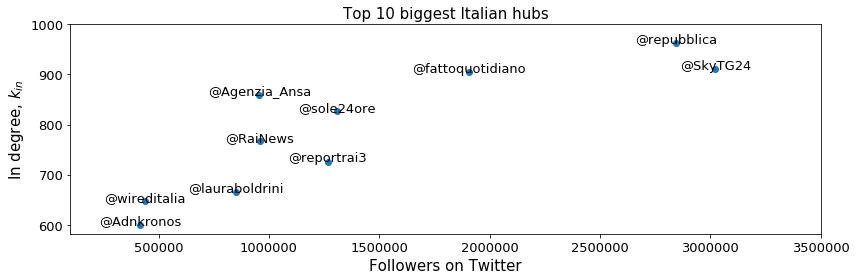

In [38]:
fig,ax = plt.subplots(figsize = (12,4))
n = 10
plt.plot(df_ita['followers'][:n], df_ita['degree'][:n], 'o')
for i in range(n):
    plt.text(df_ita['followers'].iloc[i], df_ita['degree'].iloc[i], str(df_ita['screen_name'].iloc[i]),ha ='center', fontsize =13)
plt.xlabel('Followers on Twitter')
plt.ylabel('In degree, $k_{in}$')
plt.title('Top {} biggest Italian hubs'.format(n))
#plt.xlim(xmax= 5*10**6)
plt.xlim(100000,xmax= 3.5*10**6)    
plt.ylim(ymax= 1000)
#ax.set_xscale('log')
#plt.loglog()
plt.tight_layout()
plt.savefig('./imgs/hubs_followers_ita.pdf', format='pdf')

In [39]:
df_interest_ita = df_ita.sort_values('in_degree',ascending=False).iloc[:n]
df_interest_ita = df_interest_ita.sort_values('Interest')

lab_screen =df_interest_ita['screen_name'][:n]
lab =df_interest_ita['name'][:n]
lab = lab+" "+lab_screen
nums = range(n,0,-1)
lab = [ l+", "+str(nums[i])   for i,l in enumerate(lab) ]



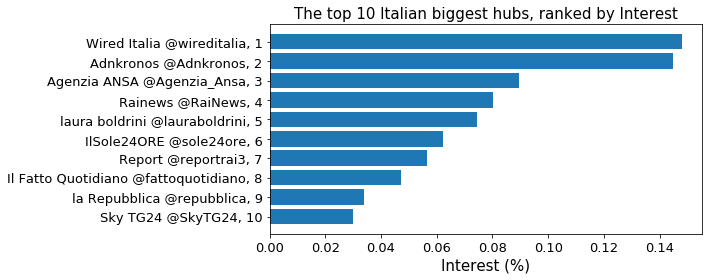

In [40]:
plt.subplots(figsize=(10,4))
X=df_interest_ita['Interest'][:n]*100
#X=df_interest['Interest'][:n]
plt.barh(range(n), X)
#plt.barh(range(n),df_interest['followers'])
##plt.barh(range(n),df_interest['C'])
plt.yticks( range(n),lab)
plt.title('The top {} Italian biggest hubs, ranked by Interest'.format(n))
plt.xlabel('Interest (%)')
plt.tight_layout()
plt.savefig('./imgs/hubs_interest_ita.pdf', format='pdf')

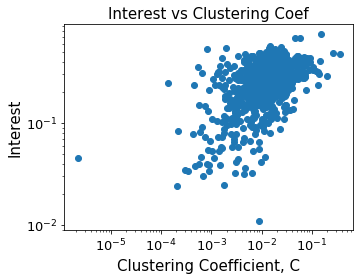

In [41]:
fig,ax = plt.subplots(figsize = FIGSIZE_ONECOL)
plt.plot(df_ita['Interest'][:1000],df_ita['C'][:1000], 'o')
ax.set_xscale('log')
plt.ylabel('Interest')
plt.xlabel('Clustering Coefficient, C')
plt.title('Interest vs Clustering Coef')
plt.tight_layout()
plt.loglog()

plt.savefig('./imgs/hubs_interest_corr_ita.pdf', format='pdf')
